# Performance Comparison of MIP Solver Formulations for Capacitated VRP

This notebook compares the performance of different formulations for the Capacitated Vehicle Routing Problem (CVRP) using MIP solvers. CVRP is a variant of the Vehicle Routing Problem (VRP) where each customer has a demand and vehicles have capacity constraints. CVRP generalizes VRP, which can be considered as a special case of CVRP.

We implement each model using JijModeling, manage optimization results with MINTO, and solve the models using SCIP. Finally, we compare the performance of each model.

## MTZ formulation and Flow formulation

For CVRP, there are two major formulations: MTZ formulation (also called potential formulation) and Flow formulation.

### About Each Formulation

MTZ formulation and Flow formulation differ in how they track cumulative demand. MTZ formulation tracks cumulative demand at each customer node, while Flow formulation tracks flow amount on each edge.

- MTZ (Miller-Tucker-Zemlin) Formulation:
    MTZ formulation introduces continuous variables representing cumulative demand at each customer node to express subtour elimination constraints. This method has relatively fewer variables and a simpler model but weaker LP relaxation.

- Flow Formulation:
    Flow formulation introduces continuous variables representing flow amount on each edge and uses flow conservation laws to express subtour elimination constraints. This method has more variables but stronger LP relaxation.

Let's implement these two formulations and compare their performance.

## Common Parts of CVRP Formulation

Let's first implement the parts common to both models.

In [10]:
import minto
import jijmodeling as jm
from minto.problems.cvrp import CVRPMTZ, CVRPFlow

## MTZ formulation

In [11]:
CVRPMTZ().problem()

## Flow formulation

In [12]:
CVRPFlow().problem()

## Random CVRP Instance Generation

We generate a random CVRP instance to test the models.

In [13]:
n = 10
instance_data = CVRPFlow().random_data(n)
xy = instance_data["xy"]

## Performance Comparison

We compare the performance of the two formulations using the random CVRP instance.
The JijModeling implementation is converted to PySCIPOpt using `ommx_pyscipopt_adapter` and solved with SCIP. Results are logged using MINTO.

When logging using `.log_instance`, we assign names to each model to make later comparison easier.

For this tutorial we set `auto_saving=False`, but in practice it is recommended to use `auto_saving=True` for automatic log saving.

In [14]:
import time
import ommx_pyscipopt_adapter as scip_ad

exp = minto.Experiment("cvrp", auto_saving=False, verbose_logging=False)

nlist = [8, 9, 10, 11, 12, 13]
for n in nlist:
    print(f"{n=}")
    with exp.run() as run:
        instance_data = CVRPFlow().random_data(n)
        run.log_parameter("n", n)
        intepreter = jm.Interpreter(instance_data)

        # MTZ model
        mtz_instance = intepreter.eval_problem(CVRPMTZ().problem())
        run.log_instance("mtz", mtz_instance)

        adapter = scip_ad.OMMXPySCIPOptAdapter(mtz_instance)
        scip_model = adapter.solver_input

        start = time.time()
        scip_model.optimize()
        scip_model.getStatus()
        elpsed_time = time.time() - start

        run.log_parameter("mtz_time", elpsed_time)

        mtz_solution = adapter.decode(scip_model)
        exp.log_solution("mtz", mtz_solution)

        # Flow model
        intepreter = jm.Interpreter(instance_data)
        flow_instance = intepreter.eval_problem(CVRPFlow().problem())
        exp.log_instance("flow", flow_instance)

        adapter = scip_ad.OMMXPySCIPOptAdapter(flow_instance)
        scip_model = adapter.solver_input

        start = time.time()
        scip_model.optimize()
        scip_model.getStatus()
        elpsed_time = time.time() - start

        exp.log_parameter("flow_time", elpsed_time)

        flow_solution = adapter.decode(scip_model)
        exp.log_solution("flow", flow_solution)


n=8
n=9
n=10
n=11
n=12
n=13


In [15]:
exp.get_run_table()

instance_mtz                                                            \
           num_vars num_binary num_integer num_continuous num_cons title name   
run_id                                                                          
0                90         81           0              9     None  None  mtz   
1               110        100           0             10     None  None  mtz   
2               132        121           0             11     None  None  mtz   
3               156        144           0             12     None  None  mtz   
4               182        169           0             13     None  None  mtz   
5               210        196           0             14     None  None  mtz   

       instance_flow                         ... solution_flow             \
            num_vars num_binary num_integer  ...      feasible optimality   
run_id                                       ...                            
0                162         81           0  ...          True          1   
1                200        100           0  ...          True          1   
2                242        121           0  ...          True          1   
3                288        144           0  ...          True          1   
4                338        169           0  ...          True          1   
5                392        196           0  ...          True          1   

                              parameter                      metadata  \
       relaxation start  name         n   mtz_time flow_time   run_id   
run_id                                                                  
0               0  None  flow         8   0.228091  0.824360        0   
1               0  None  flow         9   1.477360  1.914423        1   
2               0  None  flow        10   3.046407  1.469578        2   
3               0  None  flow        11  13.407697  3.754415        3   
4               0  None  flow        12  18.849659  3.561330        4   
5               0  None  flow        13  10.129483  2.566798        5   

                     
       elapsed_time  
run_id               
0          3.479537  
1          5.844026  
2          6.811036  
3         19.453141  
4         24.937571  
5         15.318288  

[6 rows x 31 columns]

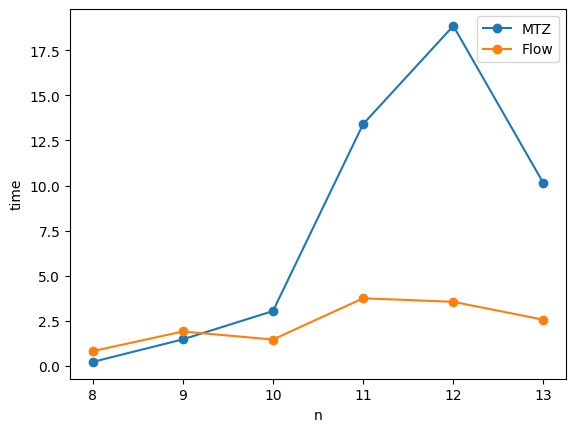

In [16]:
import matplotlib.pyplot as plt

param_table = exp.get_run_table()["parameter"]
plt.plot(param_table["n"], param_table["mtz_time"], "-o", label="MTZ")
plt.plot(param_table["n"], param_table["flow_time"], "-o", label="Flow")
plt.legend()
plt.xlabel("n")
plt.ylabel("time")
plt.show()

## Summary

In this notebook, we implemented MTZ and Flow formulations for the Capacitated Vehicle Routing Problem (CVRP) and compared their performance using a random CVRP instance. We found that the Flow formulation is faster than the MTZ formulation for the given instance.

It is interesting to note that despite having more variables, the Flow formulation performs better. This serves as a good example of how the effectiveness of branch-and-bound methods can vary depending on the constraint conditions and how easy they are to solve.

However, the performance may vary depending on the instance characteristics. For example, different vehicle capacities could lead to significantly different results. Additionally, there are strengthened versions of the MTZ formulation available.

Feel free to experiment with different instance generation methods and strengthened versions of the MTZ formulation.